In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from pprint import pprint
%matplotlib inline

In [2]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras import metrics
from keras import regularizers

Using TensorFlow backend.


In [4]:
start = datetime(2000,1,1)
end = datetime(2017,1,1)
ticker = 'FOSL'
max_shift = 30
return_shift_days = -5

In [5]:
original_data = pdr.get_data_yahoo(ticker, start, end)
original_data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

In [6]:
def to_datetime(x):
    return np.array(x, dtype=np.datetime64)

p1 = figure(x_axis_type="datetime", title="{} Closing Prices".format(ticker))
p1.grid.grid_line_alpha=0.3
p1.xaxis.axis_label = 'Date'
p1.yaxis.axis_label = 'Price'

p1.line(to_datetime(original_data.index), original_data['Close'], legend=ticker)
show(p1)

In [7]:
# original_data.to_pickle('SPY.pkl')

In [8]:
# original_data = pd.read_pickle('SPY.pkl')

In [9]:
original_data.head()

,Open,High,Low,Close
Date,,,,
1999-12-31,10.166667,10.611111,9.888889,10.277778
2000-01-03,10.277778,10.500000,9.888889,10.166667
2000-01-04,10.166667,10.166667,9.722222,9.777778
2000-01-05,9.722222,10.826356,9.722222,10.805555
2000-01-06,10.694445,10.805555,9.944445,10.000000


### Create data representation

In [10]:
data = original_data.copy()
data.columns = pd.MultiIndex.from_product([['Shift 0'],['Open','High','Low','Close']])
for i in range(1, max_shift + 1):
    shifted = data.iloc[:,[0,1,2,3]].shift(i)
    shifted.columns = pd.MultiIndex.from_product([['Shift ' + str(i)],['Open','High','Low','Close']])
    data = pd.concat([data, shifted], axis=1)

In [11]:
data.head(6)

Shift 0                                     Shift 1             \
                 Open       High        Low      Close       Open       High   
Date                                                                           
1999-12-31  10.166667  10.611111   9.888889  10.277778        NaN        NaN   
2000-01-03  10.277778  10.500000   9.888889  10.166667  10.166667  10.611111   
2000-01-04  10.166667  10.166667   9.722222   9.777778  10.277778  10.500000   
2000-01-05   9.722222  10.826356   9.722222  10.805555  10.166667  10.166667   
2000-01-06  10.694445  10.805555   9.944445  10.000000   9.722222  10.826356   
2000-01-07  10.083333  11.111111  10.083333  10.916667  10.694445  10.805555   

                                   Shift 2             ...  Shift 28        \
                 Low      Close       Open       High  ...       Low Close   
Date                                                   ...                   
1999-12-31       NaN        NaN        NaN        NaN  ...       NaN   NaN   
2000-01-03  9.888889  10.277778        NaN        NaN  ...       NaN   NaN   
2000-01-04  9.888889  10.166667  10.166667  10.611111  ...       NaN   NaN   
2000-01-05  9.722222   9.777778  10.277778  10.500000  ...       NaN   NaN   
2000-01-06  9.722222  10.805555  10.166667  10.166667  ...       NaN   NaN   
2000-01-07  9.944445  10.000000   9.722222  10.826356  ...       NaN   NaN   

           Shift 29                Shift 30                 
               Open High Low Close     Open High Low Close  
Date                                                        
1999-12-31      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-03      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-04      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-05      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-06      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-07      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  

[6 rows x 124 columns]

In [12]:
data['Shift 2', 'Close'].head(3)

Date
1999-12-31          NaN
2000-01-03          NaN
2000-01-04    10.277778
Name: (Shift 2, Close), dtype: float64

In [13]:
for i in range(0, max_shift):
    cls = data['Shift ' + str(i), 'Close']
    opn = data['Shift ' + str(i), 'Open']
    data['Shift ' + str(i), 'Bull ' + str(i)] = 100 * (cls - opn) / cls

In [14]:
data['Shift 0'].head(2)

,Open,High,Low,Close,Bull 0
Date,,,,,
1999-12-31,10.166667,10.611111,9.888889,10.277778,1.081080
2000-01-03,10.277778,10.500000,9.888889,10.166667,-1.092895


In [15]:
for i in range(0, max_shift):
    opn = data['Shift ' + str(i), 'Open']
    prv_cls = data['Shift ' + str(i+1), 'Close']
    data['Shift ' + str(i), 'GT ' + str(i)] = 100 * (opn - prv_cls) / opn

In [16]:
data[['Shift 0', 'Shift 1']].head()

Shift 0                                                       \
                 Open       High       Low      Close     Bull 0      GT 0   
Date                                                                         
1999-12-31  10.166667  10.611111  9.888889  10.277778   1.081080       NaN   
2000-01-03  10.277778  10.500000  9.888889  10.166667  -1.092895  0.000000   
2000-01-04  10.166667  10.166667  9.722222   9.777778  -3.977274  0.000000   
2000-01-05   9.722222  10.826356  9.722222  10.805555  10.025704 -0.571433   
2000-01-06  10.694445  10.805555  9.944445  10.000000  -6.944450 -1.038951   

              Shift 1                                                       
                 Open       High       Low      Close     Bull 1      GT 1  
Date                                                                        
1999-12-31        NaN        NaN       NaN        NaN        NaN       NaN  
2000-01-03  10.166667  10.611111  9.888889  10.277778   1.081080       NaN  
2000-01-04  10.277778  10.500000  9.888889  10.166667  -1.092895  0.000000  
2000-01-05  10.166667  10.166667  9.722222   9.777778  -3.977274  0.000000  
2000-01-06   9.722222  10.826356  9.722222  10.805555  10.025704 -0.571433

In [17]:
shifted = data.iloc[:,[0,1,2,3]].shift(return_shift_days)
shifted.columns = pd.MultiIndex.from_product([['Shift -5'],['Open','High','Low','Close']])
data = pd.concat([data, shifted], axis=1)

In [18]:
cls_5 = data['Shift -5', 'Close']
cls = data['Shift 0', 'Close']
data['Shift 0', 'Return'] = 100 * (cls_5 - cls) / cls_5
data.head()

Shift 0                                    Shift 1             \
                 Open       High       Low      Close       Open       High   
Date                                                                          
1999-12-31  10.166667  10.611111  9.888889  10.277778        NaN        NaN   
2000-01-03  10.277778  10.500000  9.888889  10.166667  10.166667  10.611111   
2000-01-04  10.166667  10.166667  9.722222   9.777778  10.277778  10.500000   
2000-01-05   9.722222  10.826356  9.722222  10.805555  10.166667  10.166667   
2000-01-06  10.694445  10.805555  9.944445  10.000000   9.722222  10.826356   

                                   Shift 2               ...     Shift 25  \
                 Low      Close       Open       High    ...        GT 25   
Date                                                     ...                
1999-12-31       NaN        NaN        NaN        NaN    ...          NaN   
2000-01-03  9.888889  10.277778        NaN        NaN    ...          NaN   
2000-01-04  9.888889  10.166667  10.166667  10.611111    ...          NaN   
2000-01-05  9.722222   9.777778  10.277778  10.500000    ...          NaN   
2000-01-06  9.722222  10.805555  10.166667  10.166667    ...          NaN   

           Shift 26 Shift 27 Shift 28 Shift 29   Shift -5             \
              GT 26    GT 27    GT 28    GT 29       Open       High   
Date                                                                   
1999-12-31      NaN      NaN      NaN      NaN  10.083333  11.111111   
2000-01-03      NaN      NaN      NaN      NaN  10.888889  11.111111   
2000-01-04      NaN      NaN      NaN      NaN  10.055555  10.055555   
2000-01-05      NaN      NaN      NaN      NaN   9.000000   9.027778   
2000-01-06      NaN      NaN      NaN      NaN   8.944445   9.305555   

                                    Shift 0  
                  Low      Close     Return  
Date                                         
1999-12-31  10.083333  10.916667   5.852418  
2000-01-03   9.986089   9.986089  -1.808296  
2000-01-04   8.916667   8.986089  -8.810162  
2000-01-05   8.666667   8.833333 -22.327042  
2000-01-06   8.888889   9.305555  -7.462693  

[5 rows x 189 columns]

In [19]:
binary_data = data.drop(['Open', 'High', 'Low', 'Close'], axis=1, level=1)
binary_data.head()

,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 6,Shift 7,Shift 8,Shift 9,...,Shift 21,Shift 22,Shift 23,Shift 24,Shift 25,Shift 26,Shift 27,Shift 28,Shift 29,Shift 0
,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 21,GT 22,GT 23,GT 24,GT 25,GT 26,GT 27,GT 28,GT 29,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,1.081080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.852418
2000-01-03,-1.092895,1.081080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.808296
2000-01-04,-3.977274,-1.092895,1.081080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.810162
2000-01-05,10.025704,-3.977274,-1.092895,1.081080,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.327042
2000-01-06,-6.944450,10.025704,-3.977274,-1.092895,1.08108,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.462693


In [20]:
binary_data.columns = binary_data.columns.droplevel()

In [21]:
binary_data.head(10)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 21,GT 22,GT 23,GT 24,GT 25,GT 26,GT 27,GT 28,GT 29,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,1.081080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.852418
2000-01-03,-1.092895,1.081080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.808296
2000-01-04,-3.977274,-1.092895,1.081080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.810162
2000-01-05,10.025704,-3.977274,-1.092895,1.081080,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.327042
2000-01-06,-6.944450,10.025704,-3.977274,-1.092895,1.081080,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.462693
2000-01-07,7.633594,-6.944450,10.025704,-3.977274,-1.092895,1.081080,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-18.018022
2000-01-10,-9.040576,7.633594,-6.944450,10.025704,-3.977274,-1.092895,1.081080,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.657950
2000-01-11,-11.901351,-9.040576,7.633594,-6.944450,10.025704,-3.977274,-1.092895,1.081080,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.433068
2000-01-12,-1.886796,-11.901351,-9.040576,7.633594,-6.944450,10.025704,-3.977274,-1.092895,1.081080,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.752294


# Train Keras NN

### Setup X_train, X_test, etc

In [22]:
binary_data.dropna(inplace=True)

In [23]:
X = binary_data.drop('Return', axis=1)
y = binary_data['Return'] > 0
y = np.expand_dims(y, axis=1)
y = np.hstack((y, 1 - y))

In [24]:
returns = binary_data['Return']
returns.head(10)

Date
2000-02-14     0.304880
2000-02-15     4.242425
2000-02-16    16.521736
2000-02-17    14.887638
2000-02-18    20.218583
2000-02-22     9.641871
2000-02-23     8.460259
2000-02-24     3.899723
2000-02-25     1.928370
2000-02-28    -3.977274
Name: Return, dtype: float64

In [25]:
y[0:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1]])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
print('Full data size: ', binary_data.shape[0], ' rows')
print('Train data size: ', X_train.shape[0], ' rows')

Full data size:  4243  rows
Train data size:  3394  rows


### Build model

In [29]:
model = Sequential()
model.add(Dense(max_shift*5, input_dim=X.shape[1], kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*5, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*5, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*5, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*5, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, kernel_initializer='uniform'))
model.add(Activation('softmax'))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, 
          batch_size=256, 
          verbose=2)

Train on 3394 samples, validate on 849 samples
Epoch 1/500
3s - loss: 0.7267 - acc: 0.4982 - val_loss: 0.6948 - val_acc: 0.4547
Epoch 2/500
0s - loss: 0.7172 - acc: 0.5056 - val_loss: 0.6941 - val_acc: 0.4547
Epoch 3/500
0s - loss: 0.7076 - acc: 0.5162 - val_loss: 0.6945 - val_acc: 0.4547
Epoch 4/500
0s - loss: 0.6996 - acc: 0.5115 - val_loss: 0.6937 - val_acc: 0.4547
Epoch 5/500
0s - loss: 0.6992 - acc: 0.5162 - val_loss: 0.6948 - val_acc: 0.4547
Epoch 6/500
0s - loss: 0.6958 - acc: 0.5174 - val_loss: 0.6948 - val_acc: 0.4547
Epoch 7/500
0s - loss: 0.6991 - acc: 0.5118 - val_loss: 0.6956 - val_acc: 0.4547
Epoch 8/500
0s - loss: 0.6958 - acc: 0.5200 - val_loss: 0.6961 - val_acc: 0.4547
Epoch 9/500
0s - loss: 0.6957 - acc: 0.5074 - val_loss: 0.6963 - val_acc: 0.4547
Epoch 10/500
0s - loss: 0.6937 - acc: 0.5239 - val_loss: 0.6987 - val_acc: 0.4547
Epoch 11/500
0s - loss: 0.6932 - acc: 0.5171 - val_loss: 0.6966 - val_acc: 0.4547
Epoch 12/500
0s - loss: 0.6951 - acc: 0.5150 - val_loss: 0.6

0s - loss: 0.5100 - acc: 0.7543 - val_loss: 0.9404 - val_acc: 0.4641
Epoch 102/500
0s - loss: 0.5164 - acc: 0.7448 - val_loss: 0.9571 - val_acc: 0.4688
Epoch 103/500
0s - loss: 0.5154 - acc: 0.7549 - val_loss: 0.9341 - val_acc: 0.4794
Epoch 104/500
0s - loss: 0.5044 - acc: 0.7634 - val_loss: 0.9835 - val_acc: 0.4688
Epoch 105/500
0s - loss: 0.5010 - acc: 0.7628 - val_loss: 1.0080 - val_acc: 0.4594
Epoch 106/500
0s - loss: 0.5052 - acc: 0.7519 - val_loss: 0.9730 - val_acc: 0.4629
Epoch 107/500
0s - loss: 0.5015 - acc: 0.7581 - val_loss: 1.0524 - val_acc: 0.4582
Epoch 108/500
0s - loss: 0.4920 - acc: 0.7664 - val_loss: 1.0104 - val_acc: 0.4605
Epoch 109/500
0s - loss: 0.4960 - acc: 0.7649 - val_loss: 1.0534 - val_acc: 0.4629
Epoch 110/500
0s - loss: 0.4923 - acc: 0.7640 - val_loss: 1.0430 - val_acc: 0.4664
Epoch 111/500
0s - loss: 0.4845 - acc: 0.7684 - val_loss: 1.0149 - val_acc: 0.4605
Epoch 112/500
0s - loss: 0.5010 - acc: 0.7628 - val_loss: 0.9972 - val_acc: 0.4535
Epoch 113/500
0s -

0s - loss: 0.3843 - acc: 0.8238 - val_loss: 1.2624 - val_acc: 0.4641
Epoch 201/500
0s - loss: 0.4018 - acc: 0.8129 - val_loss: 1.2139 - val_acc: 0.4629
Epoch 202/500
0s - loss: 0.3973 - acc: 0.8253 - val_loss: 1.2389 - val_acc: 0.4605
Epoch 203/500
0s - loss: 0.3954 - acc: 0.8191 - val_loss: 1.2650 - val_acc: 0.4605
Epoch 204/500
0s - loss: 0.3864 - acc: 0.8285 - val_loss: 1.2803 - val_acc: 0.4558
Epoch 205/500
0s - loss: 0.3693 - acc: 0.8374 - val_loss: 1.2751 - val_acc: 0.4629
Epoch 206/500
0s - loss: 0.3862 - acc: 0.8309 - val_loss: 1.2503 - val_acc: 0.4605
Epoch 207/500
0s - loss: 0.3785 - acc: 0.8309 - val_loss: 1.2507 - val_acc: 0.4664
Epoch 208/500
0s - loss: 0.3758 - acc: 0.8362 - val_loss: 1.2603 - val_acc: 0.4641
Epoch 209/500
0s - loss: 0.3911 - acc: 0.8194 - val_loss: 1.3211 - val_acc: 0.4535
Epoch 210/500
0s - loss: 0.3754 - acc: 0.8350 - val_loss: 1.2693 - val_acc: 0.4582
Epoch 211/500
0s - loss: 0.3938 - acc: 0.8270 - val_loss: 1.2293 - val_acc: 0.4547
Epoch 212/500
0s -

0s - loss: 0.3272 - acc: 0.8621 - val_loss: 1.3847 - val_acc: 0.4653
Epoch 300/500
0s - loss: 0.3247 - acc: 0.8615 - val_loss: 1.4617 - val_acc: 0.4723
Epoch 301/500
0s - loss: 0.3274 - acc: 0.8598 - val_loss: 1.4487 - val_acc: 0.4664
Epoch 302/500
0s - loss: 0.3341 - acc: 0.8527 - val_loss: 1.3742 - val_acc: 0.4664
Epoch 303/500
0s - loss: 0.3218 - acc: 0.8642 - val_loss: 1.3620 - val_acc: 0.4700
Epoch 304/500
0s - loss: 0.3201 - acc: 0.8683 - val_loss: 1.4098 - val_acc: 0.4735
Epoch 305/500
0s - loss: 0.3210 - acc: 0.8665 - val_loss: 1.4054 - val_acc: 0.4653
Epoch 306/500
0s - loss: 0.3141 - acc: 0.8633 - val_loss: 1.3953 - val_acc: 0.4641
Epoch 307/500
0s - loss: 0.3359 - acc: 0.8645 - val_loss: 1.3844 - val_acc: 0.4664
Epoch 308/500
0s - loss: 0.3243 - acc: 0.8662 - val_loss: 1.3262 - val_acc: 0.4605
Epoch 309/500
0s - loss: 0.3131 - acc: 0.8639 - val_loss: 1.3586 - val_acc: 0.4605
Epoch 310/500
0s - loss: 0.3291 - acc: 0.8577 - val_loss: 1.4723 - val_acc: 0.4641
Epoch 311/500
0s -

0s - loss: 0.3034 - acc: 0.8768 - val_loss: 1.3990 - val_acc: 0.4570
Epoch 399/500
0s - loss: 0.2887 - acc: 0.8795 - val_loss: 1.4366 - val_acc: 0.4570
Epoch 400/500
0s - loss: 0.2906 - acc: 0.8792 - val_loss: 1.4625 - val_acc: 0.4605
Epoch 401/500
0s - loss: 0.2849 - acc: 0.8777 - val_loss: 1.5046 - val_acc: 0.4547
Epoch 402/500
0s - loss: 0.2936 - acc: 0.8801 - val_loss: 1.5009 - val_acc: 0.4535
Epoch 403/500
0s - loss: 0.2830 - acc: 0.8848 - val_loss: 1.4499 - val_acc: 0.4605
Epoch 404/500
0s - loss: 0.2687 - acc: 0.8933 - val_loss: 1.5298 - val_acc: 0.4594
Epoch 405/500
0s - loss: 0.2777 - acc: 0.8824 - val_loss: 1.5212 - val_acc: 0.4594
Epoch 406/500
0s - loss: 0.2873 - acc: 0.8795 - val_loss: 1.4705 - val_acc: 0.4558
Epoch 407/500
0s - loss: 0.2969 - acc: 0.8739 - val_loss: 1.4205 - val_acc: 0.4511
Epoch 408/500
0s - loss: 0.2867 - acc: 0.8821 - val_loss: 1.4564 - val_acc: 0.4511
Epoch 409/500
0s - loss: 0.2989 - acc: 0.8754 - val_loss: 1.4789 - val_acc: 0.4441
Epoch 410/500
0s -

0s - loss: 0.2853 - acc: 0.8786 - val_loss: 1.5335 - val_acc: 0.4535
Epoch 498/500
0s - loss: 0.2902 - acc: 0.8877 - val_loss: 1.4855 - val_acc: 0.4511
Epoch 499/500
0s - loss: 0.2697 - acc: 0.8928 - val_loss: 1.4572 - val_acc: 0.4558
Epoch 500/500
0s - loss: 0.2738 - acc: 0.8851 - val_loss: 1.4530 - val_acc: 0.4523


In [31]:
predicted = model.predict(X_test)

In [32]:
model.evaluate(X_test, y_test)

544/849 [==================>...........] - ETA: 0s

[1.4529960880009951, 0.4522968202794258]

In [33]:
predicted[0:3]

array([[ 0.05504883,  0.94495112],
       [ 0.93478197,  0.06521806],
       [ 0.82854968,  0.17145039]], dtype=float32)

### Handle predictions

In [34]:
certainty_percentage = predicted.max(axis=0).max()*0.97
print('Certainty is', certainty_percentage, '%')
predicted_ups = predicted[:,0] > certainty_percentage
predicted_downs = predicted[:,1] > certainty_percentage

real_ups = y_test[:,0] == 1
real_downs = y_test[:,1] == 1

Certainty is 0.968599510789 %


### Visualize returns

In [35]:
test_returns = returns.iloc[X_train.shape[0]:]
print('Test period from {} to {}'.format(test_returns.index[0], test_returns.index[-1]))

Test period from 2013-08-13 00:00:00 to 2016-12-22 00:00:00


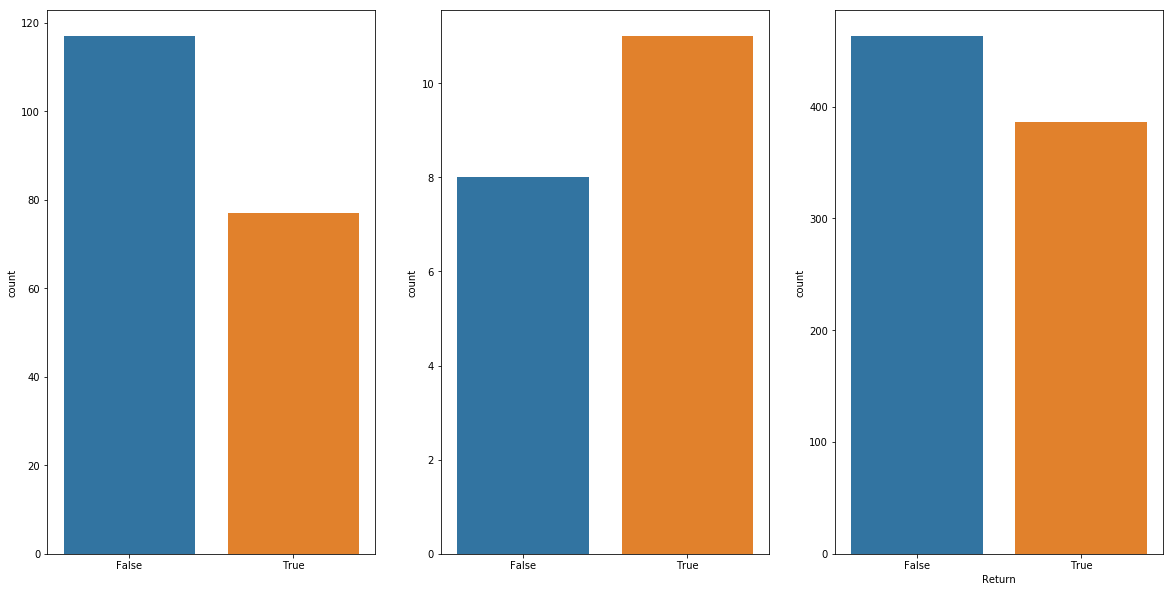

In [36]:
fig, axs = plt.subplots(ncols=3, figsize=(20,10))

if predicted_ups.any():
    sns.countplot(real_ups[predicted_ups], ax=axs[0])
if predicted_downs.any():
    sns.countplot(real_downs[predicted_downs], ax=axs[1])
    
sns.countplot(test_returns > 0, ax=axs[2])

In [37]:
def print_returns_distribution(returns):
    neg = np.sum(returns[returns < 0])
    pos = np.sum(returns[returns > 0])
    print('Negative returns: ', neg)
    print('Positive returns: ', pos)
    print('Pos/Neg ratio: ', pos/(neg*-1))
    print('Sum of returns: ', np.sum(returns))

In [38]:
real_returns = test_returns[predicted_ups].append(-1 * test_returns[predicted_downs])

In [39]:
print_returns_distribution(real_returns)

Negative returns:  -588.0474517926573
Positive returns:  464.2296314057824
Pos/Neg ratio:  0.7894424675943797
Sum of returns:  -123.817820386875


In [40]:
print_returns_distribution(test_returns)

Negative returns:  -2276.655771157373
Positive returns:  1300.8253731960465
Pos/Neg ratio:  0.5713755191610509
Sum of returns:  -975.8303979613265


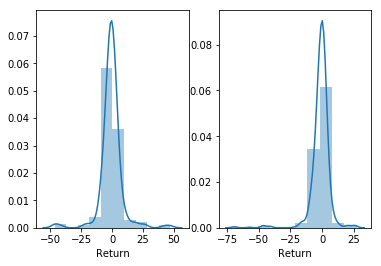

In [41]:
fig, axs = plt.subplots(ncols=2)

sns.distplot(real_returns, bins=10, ax=axs[0])
sns.distplot(test_returns, bins=10, ax=axs[1])